In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# We make an nxn grid of training points spaced every 1/(n-1) on [0,1]x[0,1]
n = 10
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
# True function is sin( 2*pi*(x0+x1))
train_y = torch.sin((train_x[:, 0] + train_x[:, 1]) * (2 * math.pi)) + torch.randn_like(train_x[:, 0]).mul(0.01)

In [49]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.WLSHKernel(
            num_samples=100, ard_num_dims=2, num_dims=2,
        ))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [56]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.max_cholesky_size(0):
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   os: %.3f    noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.covar_module.outputscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

Iter 1/50 - Loss: -0.207   lengthscale: 0.156   os: 0.930    noise: 0.000
Iter 2/50 - Loss: -0.152   lengthscale: 0.158   os: 0.871    noise: 0.000
Iter 3/50 - Loss: -0.165   lengthscale: 0.159   os: 0.828    noise: 0.000
Iter 4/50 - Loss: -0.221   lengthscale: 0.157   os: 0.829    noise: 0.000
Iter 5/50 - Loss: -0.251   lengthscale: 0.158   os: 0.845    noise: 0.000
Iter 6/50 - Loss: -0.262   lengthscale: 0.157   os: 0.870    noise: 0.000
Iter 7/50 - Loss: -0.167   lengthscale: 0.159   os: 0.891    noise: 0.000
Iter 8/50 - Loss: -0.308   lengthscale: 0.155   os: 0.904    noise: 0.000
Iter 9/50 - Loss: -0.230   lengthscale: 0.151   os: 0.897    noise: 0.000
Iter 10/50 - Loss: -0.285   lengthscale: 0.150   os: 0.872    noise: 0.000
Iter 11/50 - Loss: -0.203   lengthscale: 0.151   os: 0.839    noise: 0.000
Iter 12/50 - Loss: -0.186   lengthscale: 0.152   os: 0.802    noise: 0.000
Iter 13/50 - Loss: -0.246   lengthscale: 0.150   os: 0.769    noise: 0.000
Iter 14/50 - Loss: -0.195   length

In [57]:
model.eval()
with gpytorch.settings.prior_mode(), gpytorch.settings.max_cholesky_size(0):
    print(model(train_x).covariance_matrix)

tensor([[0.2666, 0.2041, 0.1615,  ..., 0.0000, 0.0000, 0.0000],
        [0.2041, 0.2783, 0.2536,  ..., 0.0000, 0.0000, 0.0000],
        [0.1615, 0.2536, 0.3306,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2853, 0.2258, 0.1542],
        [0.0000, 0.0000, 0.0000,  ..., 0.2258, 0.2858, 0.2174],
        [0.0000, 0.0000, 0.0000,  ..., 0.1542, 0.2174, 0.2554]],
       grad_fn=<MulBackward0>)


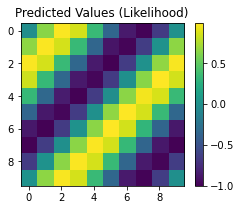

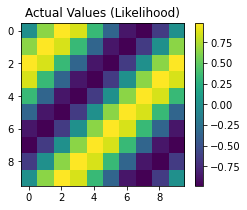

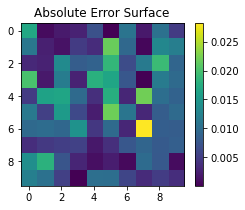

In [58]:
# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Generate nxn grid of test points spaced on a grid of size 1/(n-1) in [0,1]x[0,1]
n = 10
test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)

# Calc abosolute error
test_y_actual = torch.sin(((test_x[:, 0] + test_x[:, 1]) * (2 * math.pi))).view(n, n)
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    if smoke_test: return  # this is for running the notebook in our testing framework
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')